# Importing dependencies 

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fast')
import seaborn as sns
from ydata_profiling import ProfileReport
import missingno as msno
import category_encoders as ce
import pickle

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder,MinMaxScaler,FunctionTransformer
from imblearn.over_sampling import RandomOverSampler
from sklearn.impute import KNNImputer
from pycaret.classification import setup, compare_models
from sklearn.model_selection import train_test_split,cross_val_score
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import PowerTransformer
import optuna 
from optuna.integration import LightGBMPruningCallback
from sklearn.metrics import log_loss
import lightgbm as lgbm
from sklearn.model_selection import StratifiedKFold

# Chossing a style ( can see the list using the code : plt.style.available
plt.style.use('default')

In [3]:
# Loading csv file
df = pd.read_csv("data_science_job.csv")

# Introductory EDA

In [4]:
# Checking the shape of the dataframe
print("The shape of dataset :",df.shape)

The shape of dataset : (19158, 13)


In [5]:
# Checking any 5 random rows
df.sample(5)

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,training_hours,target
7852,24518,city_73,0.754,Other,Has relevent experience,Part time course,High School,NaN,10.0,10000+,NaN,22.0,0.0
15501,19968,city_21,0.624,Male,No relevent experience,no_enrollment,High School,NaN,5.0,NaN,NaN,51.0,1.0
2287,2069,city_114,0.926,Female,Has relevent experience,no_enrollment,Masters,Humanities,20.0,<10,Pvt Ltd,66.0,0.0
7077,27758,city_103,0.920,NaN,Has relevent experience,no_enrollment,Graduate,STEM,NaN,<10,Pvt Ltd,19.0,0.0
18975,27204,city_160,0.920,Female,Has relevent experience,no_enrollment,Graduate,STEM,3.0,NaN,NaN,33.0,0.0


**Observation** 🔍

Out of all the features present in our dataset enrollee_id and city will be not be useful features for figuring out wheter a person will get job or not, so we will simply remove these features from our dataset.

In [6]:
# Let's get some basic informatin about the features
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             19158 non-null  int64  
 1   city                    19158 non-null  object 
 2   city_development_index  18679 non-null  float64
 3   gender                  14650 non-null  object 
 4   relevent_experience     19158 non-null  object 
 5   enrolled_university     18772 non-null  object 
 6   education_level         18698 non-null  object 
 7   major_discipline        16345 non-null  object 
 8   experience              19093 non-null  float64
 9   company_size            13220 non-null  object 
 10  company_type            13018 non-null  object 
 11  training_hours          18392 non-null  float64
 12  target                  19158 non-null  float64
dtypes: float64(4), int64(1), object(8)
memory usage: 1.9+ MB


**Observation** 🔍

1. There are missing values in some features.
2. For storing the numerical values currently int64 and float64 are getting used, but we can reduce the memory usage by using correct datatypes such as int32 and float32

In [7]:
# Optimizing the memory by using appropriate data types
int_cols = df.select_dtypes(include=np.int64)
float_cols = df.select_dtypes(include=np.float64)

df[int_cols.columns] = df[int_cols.columns].astype(np.int32)
df[float_cols.columns] = df[float_cols.columns].astype(np.float32)

- Before memory usage : 1.9 mb
- After memory usage : 1.5 mb

In [8]:
# Descriptive information about the data
df.describe()

,enrollee_id,city_development_index,experience,training_hours,target
count,19158.000000,18679.000000,19093.000000,18392.000000,19158.000000
mean,16875.358179,0.828951,9.928037,65.185791,0.249348
std,9616.292592,0.123334,6.505268,59.885624,0.432647
min,1.000000,0.448000,0.000000,1.000000,0.000000
25%,8554.250000,0.740000,4.000000,23.000000,0.000000
50%,16982.500000,0.903000,9.000000,47.000000,0.000000
75%,25169.750000,0.920000,16.000000,88.000000,0.000000
max,33380.000000,0.949000,20.000000,336.000000,1.000000


**Observation** 🔍

By observing the 25 , 50 and 75 percentile of 
- city_developemnt_index
- experience
- training_hours
  
I am getting an indication that there can be some outliers in these features.

Percentages of missing values : 
enrollee_id                0.000000
city                       0.000000
city_development_index     2.500261
gender                    23.530640
relevent_experience        0.000000
enrolled_university        2.014824
education_level            2.401086
major_discipline          14.683161
experience                 0.339284
company_size              30.994885
company_type              32.049274
training_hours             3.998330
target                     0.000000
dtype: float64


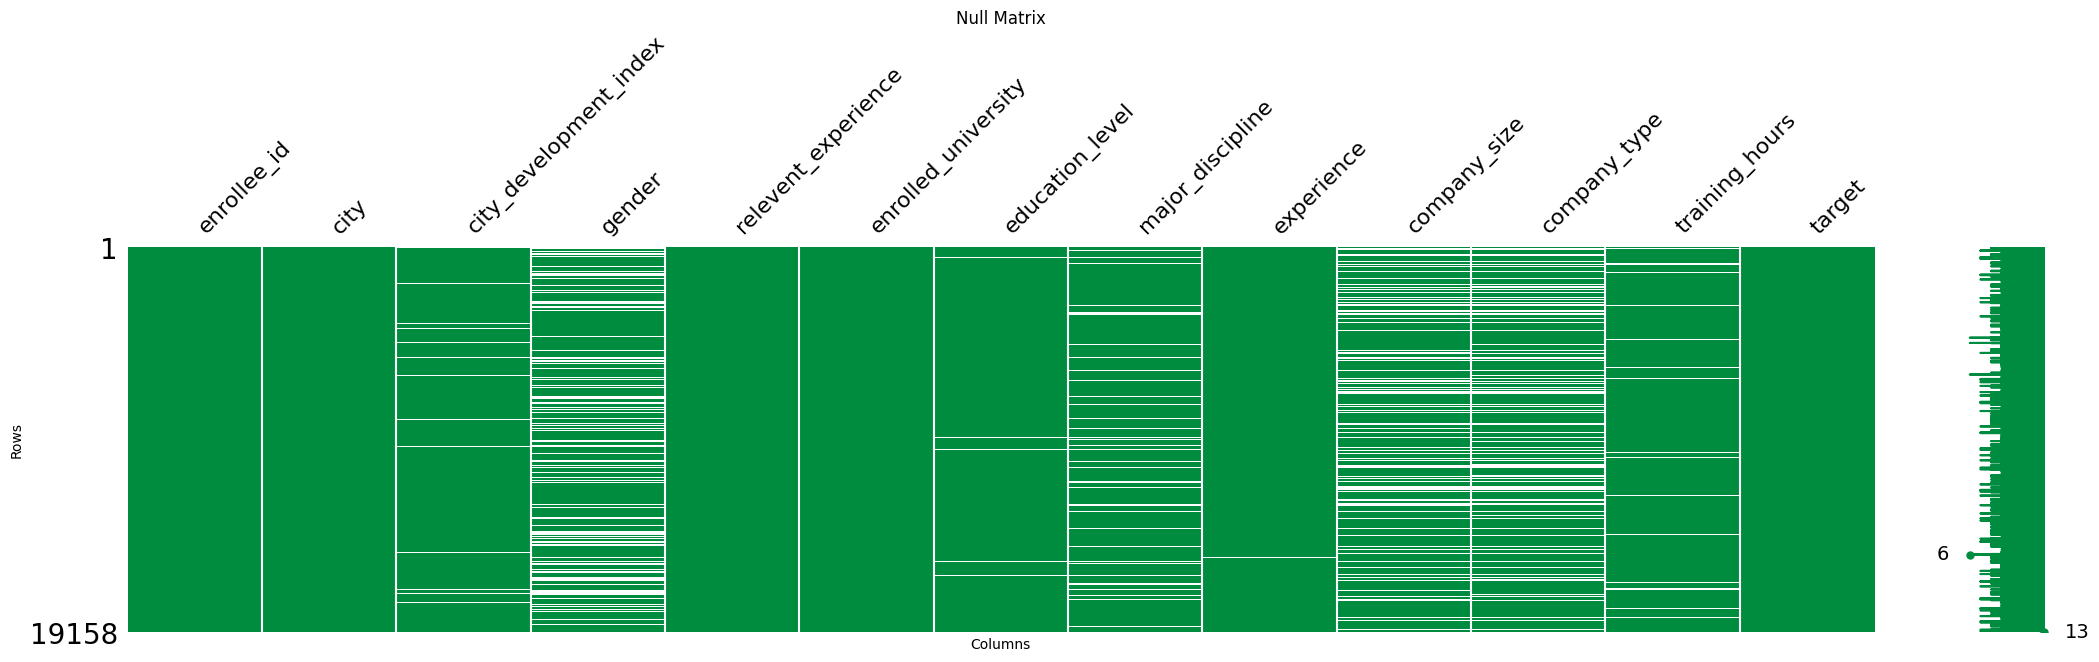

In [9]:
# Checking percentage of null values
print("Percentages of missing values : ")
print(df.isnull().mean()*100)

# Plot the null matrix to visualize if there are null values left
msno.matrix(df,figsize=(25, 5),color=(0, 0.55, 0.25))

# Set plot labels and title
plt.xlabel('Columns')
plt.ylabel('Rows')
plt.title('Null Matrix')

# Show the plot
plt.show()

In [10]:
# Checking number of duplicate values
print("Total duplicate values :",df.duplicated().sum())

Total duplicate values : 0


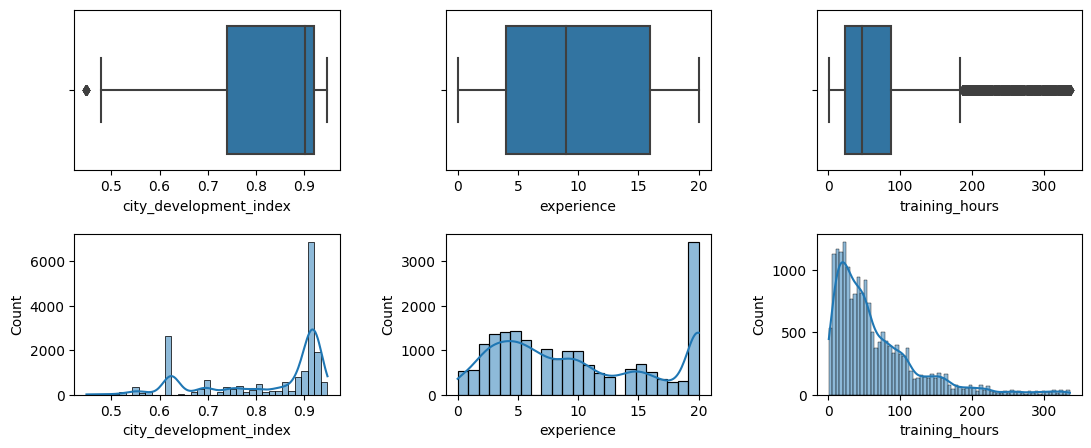

In [11]:
# Let's check if there are any outliers in the numerical columns and their corresponding distribution
fig,ax = plt.subplots(2,3,figsize=(13,5))

sns.boxplot(x = df['city_development_index'],ax = ax[0][0])
sns.boxplot(x = df['experience'],ax = ax[0][1])
sns.boxplot(x = df['training_hours'],ax = ax[0][2])

sns.histplot(data = df['city_development_index'],ax = ax[1][0],kde=True)
sns.histplot(data = df['experience'],ax = ax[1][1],kde=True)
sns.histplot(data = df['training_hours'],ax = ax[1][2],kde=True)


plt.subplots_adjust(hspace=0.4,wspace=0.4)
plt.show()

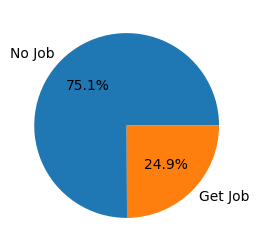

In [12]:
# Plot a pie chart 0 -> No job and 1 -> Get job
fig,ax = plt.subplots(figsize = (3,3))

plt.pie(df['target'].value_counts(), labels=['No Job', 'Get Job'],autopct='%1.1f%%')
plt.show()

**Observation** 🔍

The overall distribution of data across the class labels is not constant, so we need to make sure that we dealing with imbalance in our dataset by using some sampling technique.

Now the thing which we must keep in mind is that we should do data augmentation only after processing the data, because before data processing there are high chances that our data might not be good, like it might be having some outliers and things like that, so it is always reccomended to do the data augmentaton or sampling after data processing.

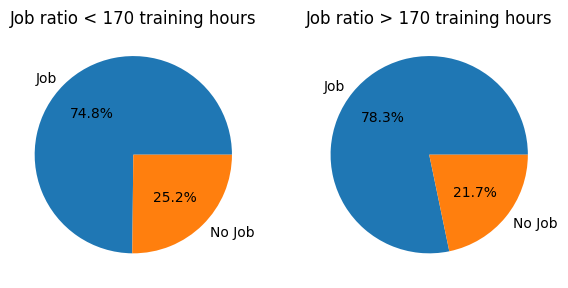

In [13]:
# Let's see job ratio for training hours less than 170 and more than 170
check1 = df['target'][(df['training_hours'] < 170) & (df['training_hours'] > 0)]
check2 = df['target'][(df['training_hours'] > 170)]

# Plot a pie chart 0 -> No job and 1 -> Get job
fig,ax = plt.subplots(1,2,figsize = (7,7))

ax[0].pie(check1.value_counts(), labels=['Job', 'No Job'],autopct='%1.1f%%')
ax[0].set_title("Job ratio < 170 training hours")

ax[1].pie(check2.value_counts(), labels=['Job', 'No Job'],autopct='%1.1f%%')
ax[1].set_title("Job ratio > 170 training hours")
plt.show()

# Data Cleaning and processing

Other than basic descriptive statistical technqiques which we used above, there are a lot of other questions in which I am interested in but, before trying to find out the we need to process and clean our data and this would include

1. Dropping unnecessary columns
2. Dealing with missing values
3. Dealing with outliers
4. Encoding the categorical values

After doing above preprocessing steps we can again explore our data and after exploration we will augment our data to balance uneven class distribution to train our model.

In [14]:
# Dropping the unnecessary columns from the dataframe
df = df.drop(['enrollee_id','city'],axis=1)
df.head(3)

,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,training_hours,target
0,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,20.0,NaN,NaN,36.0,1.0
1,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15.0,50-99,Pvt Ltd,47.0,0.0
2,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5.0,NaN,NaN,83.0,0.0


In [15]:
print("Before duplicate values:",df.duplicated().sum())
df.drop_duplicates(inplace=True)
print("After duplicate values:",df.duplicated().sum())

Before duplicate values: 194
After duplicate values: 0


In [16]:
# Using pandas profiling 
prof = ProfileReport(df)
prof.to_file(output_file='Summary.html')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

For the complete data processing we will be creating a pipeline, but before making a pipeling we need to explore all the techniques which we can use to process our data in most efficient way and for this we will simply create a copy of the dataframe.

In [16]:
# Creating a copy of the dataframe
temp_df = df.copy()
temp_df.head(3)

,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,training_hours,target
0,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,20.0,NaN,NaN,36.0,1.0
1,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15.0,50-99,Pvt Ltd,47.0,0.0
2,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5.0,NaN,NaN,83.0,0.0


### Dealing with missing values

In order to deal with missing values we can either impute them or we can remove them. Generally for the features having percentage of missing values less than 5% it is said to remove the missing values. But in order to retain as much data as possible we will compare the effect of both removing and imputing the missing values.

In [17]:
# Let's take out features having missing value percentage less than 5% 
Less_5PER = [col for col in temp_df.columns if temp_df[col].isnull().mean()*100 <5 and temp_df[col].isnull().mean()*100>0]

# Let's create 2 copy to compare the change in distribution
remove_nan = temp_df[Less_5PER].copy()
impute_nan = temp_df[Less_5PER].copy()

In [18]:
# Dropping all the rows having column values as NaN
remove_nan.dropna(inplace=True)

# Mean imputation
mean_impute_cols = ['city_development_index','experience','training_hours']
mode_impute_cols = ['enrolled_university','education_level']

for cols in mean_impute_cols:
    impute_nan[cols].fillna(impute_nan[cols].mean(),inplace=True)

for cols in mode_impute_cols:
    impute_nan[cols].fillna(impute_nan[cols].mode()[0],inplace=True)

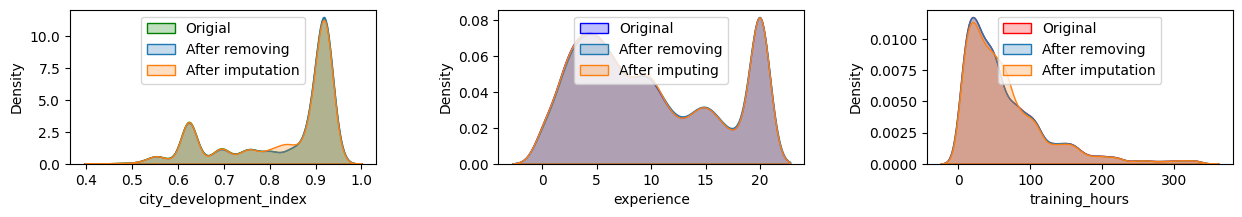

In [19]:
# Now let's visualize the distributions before and after implemnting CCA on numerical features
fig, ax = plt.subplots(1, 3, figsize=(15, 2))

sns.kdeplot(temp_df['city_development_index'], fill=True,ax=ax[0], color='green', label='Origial')
sns.kdeplot(remove_nan['city_development_index'], fill=True,ax=ax[0], label='After removing')
sns.kdeplot(impute_nan['city_development_index'], fill=True,ax=ax[0], label='After imputation')
ax[0].legend(loc='upper center')

sns.kdeplot(temp_df['experience'], fill=True,ax=ax[1], color='blue', label='Original')
sns.kdeplot(remove_nan['experience'], fill=True,ax=ax[1], label='After removing')
sns.kdeplot(impute_nan['experience'], fill=True,ax=ax[1], label='After imputing')
ax[1].legend(loc='upper center')

sns.kdeplot(temp_df['training_hours'], fill=True,ax=ax[2], color='red', label='Original')
sns.kdeplot(remove_nan['training_hours'], fill=True,ax=ax[2], label='After removing')
sns.kdeplot(impute_nan['training_hours'], fill=True,ax=ax[2], label='After imputation')
ax[2].legend(loc='upper center')

plt.subplots_adjust(hspace=0.4,wspace=0.4)
plt.show()

For the categorical columns we will check the ratio of categories before and after applying CCA

In [20]:
# For the categorical features we will check the ratio of classes before and after implementing CCA
compare_eu = pd.concat([temp_df['enrolled_university'].value_counts() / len(temp_df),
                    remove_nan['enrolled_university'].value_counts() / len(remove_nan),
                    impute_nan['enrolled_university'].value_counts()/len(impute_nan)],axis=1)

compare_eu.columns = ['Original','After removing','After imputation']
compare_eu

,Original,After removing,After imputation
no_enrollment,0.718888,0.732981,0.739243
Full time course,0.197585,0.202293,0.197585
Part time course,0.063172,0.064727,0.063172


In [21]:
compare_edu_level = pd.concat([ temp_df['education_level'].value_counts() / len(temp_df),
                        remove_nan['education_level'].value_counts() / len(remove_nan),
                        impute_nan['education_level'].value_counts()/len(impute_nan)],axis=1)

compare_edu_level.columns = ['Original','After removing','After imputation']
compare_edu_level

,Original,After removing,After imputation
Graduate,0.602668,0.617284,0.626872
Masters,0.229066,0.235567,0.229066
High School,0.105990,0.108054,0.105990
Phd,0.021831,0.022340,0.021831
Primary School,0.016241,0.016755,0.016241


**Observation** 🔍

From my analysis I can clearly see that for all the columns having percentage of missing values less than 5% the distribution is not changing a lot after imputation in the numerical features and for the categorical features as well the ratio is not changing a lot after imputation, thus to keep as much data as we can we will imputing the missing values instead of removing them.

Also for the other columns like Gender, major discipline, company size and company type we will be using advance imputation technique like KNN imputer in this case.

In [22]:
# Mean imputation
mean_impute_cols = ['city_development_index','experience','training_hours']
mode_impute_cols = ['enrolled_university','education_level']

for cols in mean_impute_cols:
    temp_df[cols].fillna(temp_df[cols].mean(),inplace=True)

for cols in mode_impute_cols:
    temp_df[cols].fillna(temp_df[cols].mode()[0],inplace=True)

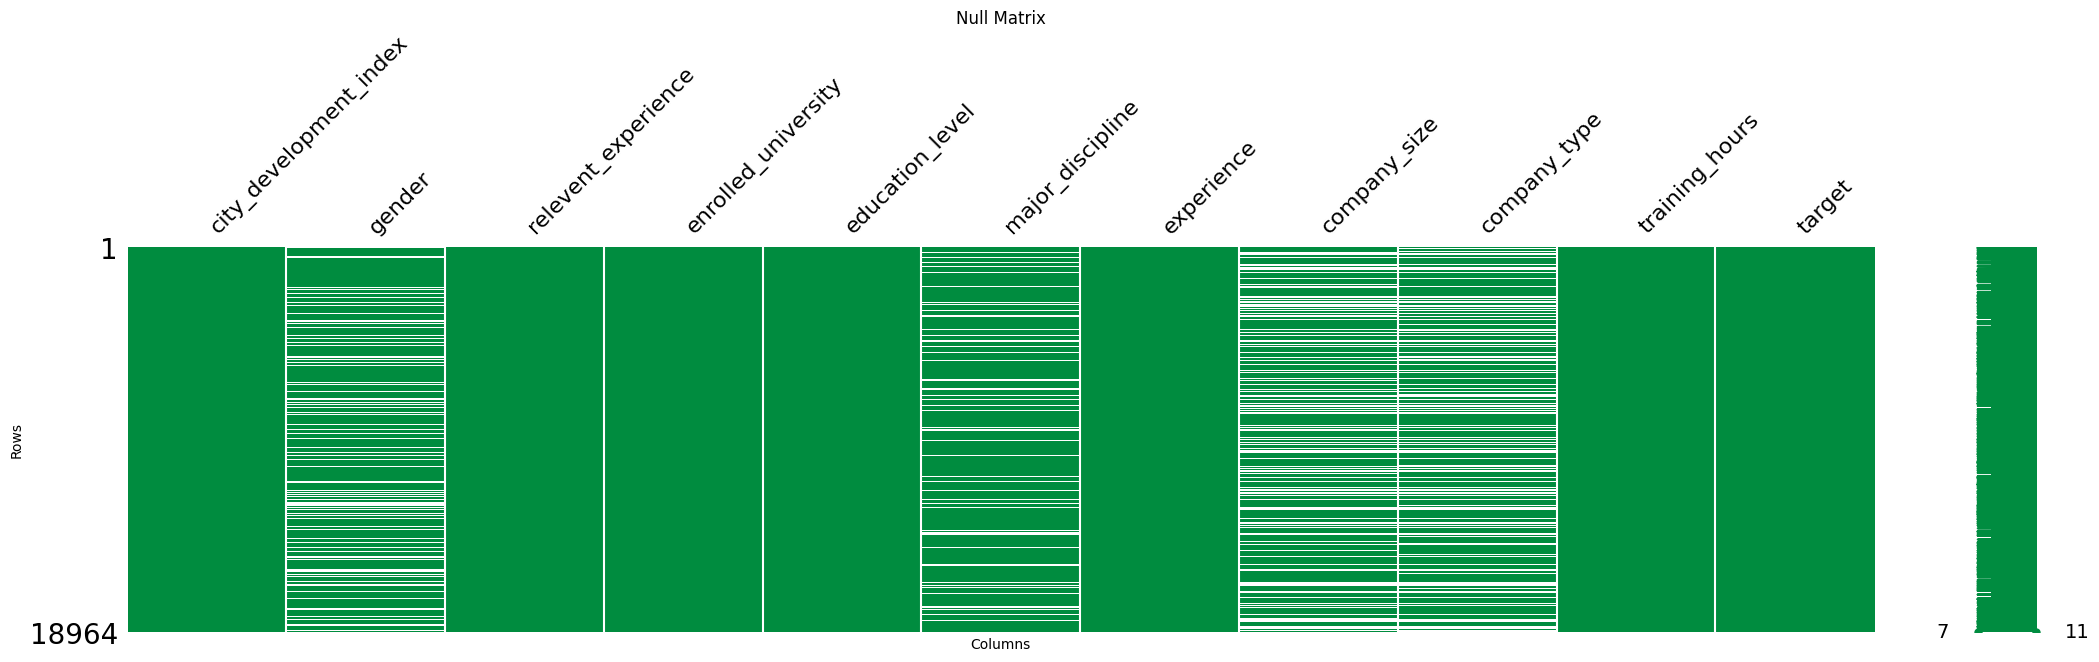

In [23]:
# Plot the null matrix to visualize if there are null values left
msno.matrix(temp_df,figsize=(25, 5),color=(0, 0.55, 0.25))

# Set plot labels and title
plt.xlabel('Columns')
plt.ylabel('Rows')
plt.title('Null Matrix')

# Show the plot
plt.show()

### Dealing with outliers

Let's now deal with the outliers. From the previous analysis we got to know that city_development_index and training_hours both had outliers and both of these features had a skewness in thier distribution. city_development_index have left skewness and training_hours have right skewness.

For dealing with outiers we can either remove them, cap them or we can either transform the entire data using some mathematical transformation. So for now we will be transforming the skewed data in both the features using YEO-Johsson transformation.

In [24]:
# Apply Yeo-Johnson transformation
pt_yeo = PowerTransformer()

temp_df[['city_development_index','training_hours']] = pt_yeo.fit_transform(temp_df[['city_development_index','training_hours']])

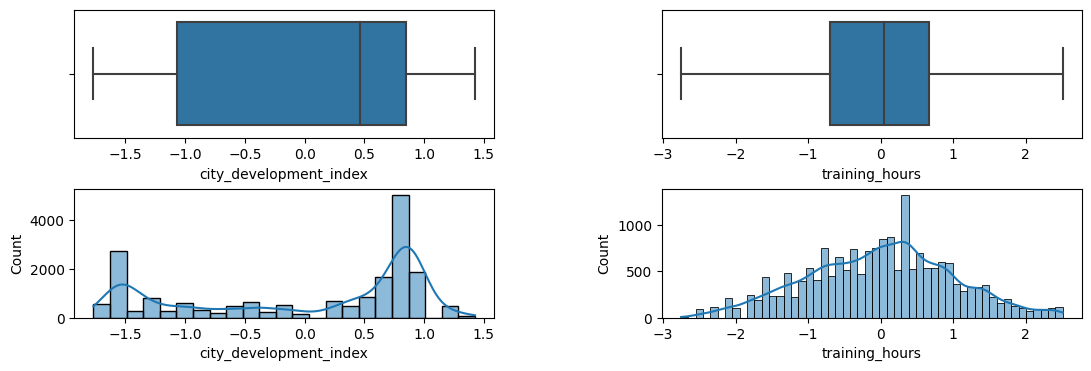

In [25]:
# Let's check if there are any outliers in the numerical columns and their corresponding distribution
fig,ax = plt.subplots(2,2,figsize=(13,4))

sns.boxplot(x = temp_df['city_development_index'],ax = ax[0][0])
sns.boxplot(x = temp_df['training_hours'],ax = ax[0][1])

sns.histplot(data = temp_df['city_development_index'],ax = ax[1][0],kde=True)
sns.histplot(data = temp_df['training_hours'],ax = ax[1][1],kde=True)

plt.subplots_adjust(hspace=0.4,wspace=0.4)
plt.show()

### Dealing with categorical columns

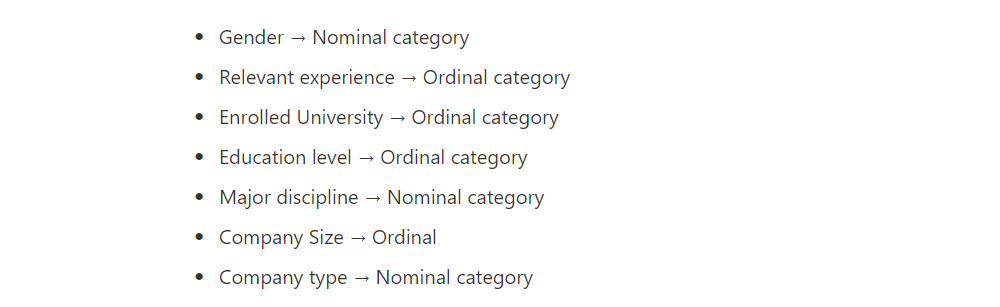

🚨 An important thing we must keep in mind is that for dealing with the nominal categorical values we can either use one hot encoding or target encoding. But the use of any of the technique is totally based on the cardinality of the column.

If there is high cardinality ➡️ Target encoding
If there is less cardinality ➡️ One hot encoding

### Feature selection/Extraction

# Creation of Pipeline

As we have explored all the techniques which we will be using to deal with misssing values, outliers and cateogircal features. We will now create a pipeline that will do all the data cleaning and processing in a streamlined process.

- First we will create a column transformer to deal with missing values ( Simple imputtation techniques )
- Then we will create a column transformer for doing ordinal and target encoding
- After doing encoding we will use KNN imputer to impute the columns which were having high missing values percentage
- Followed by this we will scale our values
- Finally we will be using a machine learning model for training

**Down below is the descirption all the change in column positions after the data will go through each and every column transformer**

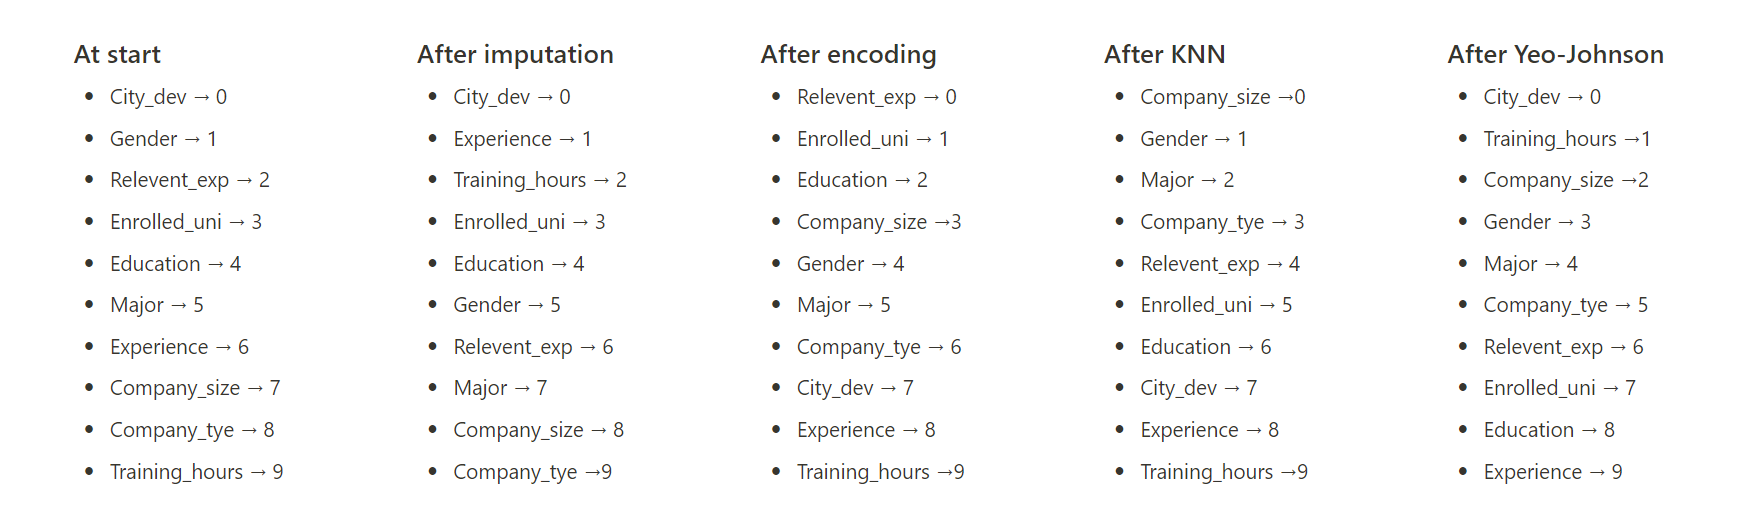

In [26]:
# Define the column transformer for imputation
Simple_impute_transformer = ColumnTransformer(transformers=[
    ('mean_imputer', SimpleImputer(strategy='mean'), [0, 6, 9]),
    ('mode_imputer', SimpleImputer(strategy='most_frequent'), [3, 4])        
], remainder='passthrough')

# Define the column transformer for encoding
encode_values = ColumnTransformer(transformers=[
    ('Encode_ordinal_Re', OrdinalEncoder(categories=[['No relevent experience', 'Has relevent experience']],handle_unknown='use_encoded_value', unknown_value=np.nan), [6]),
    ('Encode_ordinal_eu', OrdinalEncoder(categories=[['no_enrollment', 'Part time course', 'Full time course']],handle_unknown='use_encoded_value', unknown_value=np.nan), [3]),
    ('Encode_ordinal_el', OrdinalEncoder(categories=[['Primary School', 'High School', 'Graduate', 'Masters', 'Phd']],handle_unknown='use_encoded_value', unknown_value=np.nan), [4]),
    ('Encode_ordinal_cs', OrdinalEncoder(categories=[['<10', '10/49', '50-99', '100-500', '500-999', '1000-4999', '5000-9999', '10000+']],handle_unknown='use_encoded_value', unknown_value=np.nan), [8]),
    ('Encode_target_gen', ce.TargetEncoder(smoothing=0.2, handle_missing='return_nan'), [5]),
    ('Encode_target_major', ce.TargetEncoder(smoothing=0.2, handle_missing='return_nan'), [7]),
    ('Encode_target_ct', ce.TargetEncoder(smoothing=0.2, handle_missing='return_nan'), [9])
], remainder='passthrough')

# Imputing using KNN imputer
Knn_imputer = ColumnTransformer(transformers=[
    ('Knn_Imputer', KNNImputer(n_neighbors=5, metric='nan_euclidean'), [3,4, 5, 6])
], remainder='passthrough')

# Applying YEO-Johenson transformation
yeo_transformation = ColumnTransformer(transformers = [
    ('Yeo_johnson',PowerTransformer(),[7,9])
],remainder='passthrough')


# Column transformer to do feature scaling
scaling_transformer = ColumnTransformer(transformers=[
    ('scale_transformer', MinMaxScaler(), [0,1,9])
], remainder='passthrough')

#Algorithm = RandomForestClassifier(n_estimators=100)

# Define the final pipeline
pipe = Pipeline(steps=[
    ('impute_transformer', Simple_impute_transformer),
    ('encode_values', encode_values),
    ('Knn_imputer', Knn_imputer),
    ('yeo_transformation',yeo_transformation),
    ('Scaling', scaling_transformer)
    #('ML_Model', Algorithm)
])


In [27]:
# Seperating the data into dependent and independnet variable
X = df.drop(['target'],axis=1)
y = df['target']

# Let's split the data into train,test and validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

In [28]:
X_train = pipe.fit_transform(X_train,y_train)

In [29]:
# Seperating the data into dependent and independent variable
y = y_train
X = X_train

# Instantiate the SMOTE algorithm
smote = SMOTE()

# Apply SMOTE to oversample the minority class
X_rs, y_rs = smote.fit_resample(X, y)

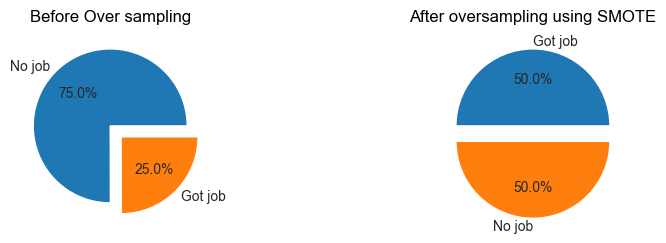

In [30]:
# Let's visualize distribution of the classes in the target variable before and after 
fig,ax = plt.subplots(1,2,figsize=(10,2.5))
ex = (0,0.2)
sns.set_style("whitegrid")

ax[0].pie(df['target'].value_counts(), labels=['No job','Got job'], autopct='%1.1f%%', explode=ex)
ax[0].set(title='Before Over sampling')
ax[1].pie(y_rs.value_counts(), labels=['Got job','No job'], autopct='%1.1f%%', explode=ex)
ax[1].set(title='After oversampling using SMOTE')

# show the plot
plt.show()

# Model comparision

In [67]:
# initialize setup with preprocessing
clf = setup(X_rs, target=y_rs,preprocess= False,use_gpu=True)

# compare selected models
best_model = compare_models(include= ['lr', 'knn', 'nb', 'dt', 'svm', 'rbfsvm', 'gpc', 'mlp', 'ridge',
       'rf', 'qda', 'ada', 'gbc', 'lda', 'et', 'lightgbm'],fold =6)

,Description,Value
0,Session id,8550
1,Target,target
2,Target type,Binary
3,Original data shape,"(17188, 11)"
4,Transformed data shape,"(17188, 11)"
5,Transformed train set shape,"(12031, 11)"
6,Transformed test set shape,"(5157, 11)"
7,Numeric features,10


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.8457,0.9163,0.8515,0.8419,0.8466,0.6915,0.6916,2.0350
et,Extra Trees Classifier,0.8297,0.8960,0.8362,0.8256,0.8307,0.6594,0.6597,1.6367
rf,Random Forest Classifier,0.8294,0.9010,0.8263,0.8316,0.8288,0.6589,0.6590,2.4517
gbc,Gradient Boosting Classifier,0.8061,0.8782,0.8190,0.7984,0.8085,0.6122,0.6124,2.5567
ada,Ada Boost Classifier,0.7763,0.8486,0.7884,0.7700,0.7790,0.5527,0.5529,1.2000
dt,Decision Tree Classifier,0.7562,0.7564,0.7531,0.7579,0.7554,0.5124,0.5125,0.3217
knn,K Neighbors Classifier,0.7487,0.8132,0.8216,0.7171,0.7658,0.4975,0.5029,1.5867
mlp,MLP Classifier,0.7181,0.7808,0.6929,0.7301,0.7105,0.4363,0.4374,26.0800
gpc,Gaussian Process Classifier,0.7118,0.7718,0.7149,0.7105,0.7127,0.4237,0.4237,182.5150
rbfsvm,SVM - Radial Kernel,0.6872,0.7492,0.7049,0.6808,0.6926,0.3744,0.3747,58.0100


Since we can clearly see that Light Gradient Boosting Machiner is performing the best so we will use this algorithm, but the thing to keep in mind is that the comparision between the models have been done on the basis of some default values of hyper-parameters thus there are still chances of getting better results than current results.

# Hyper-paramter tuning and model training

ValueError: DataFrame.dtypes for data must be int, float or bool.
Did not expect the data types in the following fields: city_development_index, experience, training_hours, company_size, gender, major_discipline, company_type, relevent_experience, enrolled_university, education_level

In [58]:
X_rs = pd.DataFrame(X_rs)

In [57]:
def objective(trial, X, y):
    param_grid = {
        # "device_type": trial.suggest_categorical("device_type", ['gpu']),
        "n_estimators": trial.suggest_categorical("n_estimators", [10000]),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "num_leaves": trial.suggest_int("num_leaves", 20, 3000, step=20),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 200, 10000, step=100),
        "lambda_l1": trial.suggest_int("lambda_l1", 0, 100, step=5),
        "lambda_l2": trial.suggest_int("lambda_l2", 0, 100, step=5),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
        "bagging_fraction": trial.suggest_float(
            "bagging_fraction", 0.2, 0.95, step=0.1
        ),
        "bagging_freq": trial.suggest_categorical("bagging_freq", [1]),
        "feature_fraction": trial.suggest_float(
            "feature_fraction", 0.2, 0.95, step=0.1
        ),
    }

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1121218)

    cv_scores = np.empty(5)
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        model = lgbm.LGBMClassifier(objective="binary", **param_grid,silent=True)
        model.fit(
            X_train,
            y_train,
            eval_set=[(X_test, y_test)],
            eval_metric="binary_logloss",
            early_stopping_rounds=100,
            callbacks=[
                LightGBMPruningCallback(trial, "binary_logloss")
            ],  # Add a pruning callback
        )
        preds = model.predict_proba(X_test)
        cv_scores[idx] = log_loss(y_test, preds)

    return np.mean(cv_scores)

study = optuna.create_study(direction="minimize", study_name="LGBM Classifier")  # Use "maximize" for F1 score
func = lambda trial: objective(trial, X_rs, y_rs)
study.optimize(func, n_trials=20)

[I 2023-06-28 23:10:38,534] A new study created in memory with name: LGBM Classifier


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=1700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1700
[LightGBM] [Warning] min_gain_to_split is set=2.8821830895737777, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.8821830895737777
[LightGBM] [Warning] lambda_l1 is set=50, reg_alpha=0.0 will be ignored. Current value: lambda_l1=50
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Cur

[I 2023-06-28 23:10:54,992] Trial 0 finished with value: 0.5999977828967447 and parameters: {'n_estimators': 10000, 'learning_rate': 0.06616813682714696, 'num_leaves': 320, 'max_depth': 8, 'min_data_in_leaf': 1700, 'lambda_l1': 50, 'lambda_l2': 15, 'min_gain_to_split': 2.8821830895737777, 'bagging_fraction': 0.30000000000000004, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001}. Best is trial 0 with value: 0.5999977828967447.


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=7300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7300
[LightGBM] [Warning] min_gain_to_split is set=2.9096627005175697, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.9096627005175697
[LightGBM] [Warning] lambda_l1 is set=85, reg_alpha=0.0 will be ignored. Current value: lambda_l1=85
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=

[I 2023-06-28 23:10:55,875] Trial 1 finished with value: 0.6931471900810682 and parameters: {'n_estimators': 10000, 'learning_rate': 0.011662858678658065, 'num_leaves': 1040, 'max_depth': 10, 'min_data_in_leaf': 7300, 'lambda_l1': 85, 'lambda_l2': 90, 'min_gain_to_split': 2.9096627005175697, 'bagging_fraction': 0.5, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004}. Best is trial 0 with value: 0.5999977828967447.


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=7300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7300
[LightGBM] [Warning] min_gain_to_split is set=2.9096627005175697, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.9096627005175697
[LightGBM] [Warning] lambda_l1 is set=85, reg_alpha=0.0 will be ignored. Current value: lambda_l1=85
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [

[I 2023-06-28 23:11:00,090] Trial 2 finished with value: 0.5896061477704013 and parameters: {'n_estimators': 10000, 'learning_rate': 0.08790566426817874, 'num_leaves': 1680, 'max_depth': 3, 'min_data_in_leaf': 3000, 'lambda_l1': 85, 'lambda_l2': 95, 'min_gain_to_split': 13.07171068210076, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 2 with value: 0.5896061477704013.


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=1800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1800
[LightGBM] [Warning] min_gain_to_split is set=4.534076543637896, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.534076543637896
[LightGBM] [Warning] lambda_l1 is set=80, reg_alpha=0.0 will be ignored. Current value: lambda_l1=80
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=70, reg_lambda=0.0 will be ignored. Current value: lambda_l2=70
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.

[I 2023-06-28 23:11:02,527] Trial 3 finished with value: 0.560466701513408 and parameters: {'n_estimators': 10000, 'learning_rate': 0.252412223415618, 'num_leaves': 1460, 'max_depth': 10, 'min_data_in_leaf': 1800, 'lambda_l1': 80, 'lambda_l2': 70, 'min_gain_to_split': 4.534076543637896, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004}. Best is trial 3 with value: 0.560466701513408.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=8100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8100
[LightGBM] [Warning] min_gain_to_split is set=14.435437683555756, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.435437683555756
[LightGBM] [Warning] lambda_l1 is set=100, reg_alpha=0.0 will be ignored. Current value: lambda_l1=100
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is s

[I 2023-06-28 23:11:03,358] Trial 4 finished with value: 0.6931471900810682 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1997281020559901, 'num_leaves': 1320, 'max_depth': 4, 'min_data_in_leaf': 8100, 'lambda_l1': 100, 'lambda_l2': 15, 'min_gain_to_split': 14.435437683555756, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 3 with value: 0.560466701513408.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=8100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8100
[LightGBM] [Warning] min_gain_to_split is set=14.435437683555756, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.435437683555756
[LightGBM] [Warning] lambda_l1 is set=100, reg_alpha=0.0 will be ignored. Current value: lambda_l1=100
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is s

[I 2023-06-28 23:11:03,397] Trial 5 pruned. Trial was pruned at iteration 0.
[I 2023-06-28 23:11:03,446] Trial 6 pruned. Trial was pruned at iteration 0.
[I 2023-06-28 23:11:03,488] Trial 7 pruned. Trial was pruned at iteration 0.
[I 2023-06-28 23:11:03,533] Trial 8 pruned. Trial was pruned at iteration 0.
[I 2023-06-28 23:11:03,774] Trial 9 pruned. Trial was pruned at iteration 101.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=6.103249014088191, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.103249014088191
[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=55, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=500

[I 2023-06-28 23:11:06,944] Trial 10 finished with value: 0.4987453691534299 and parameters: {'n_estimators': 10000, 'learning_rate': 0.29478089724200374, 'num_leaves': 40, 'max_depth': 12, 'min_data_in_leaf': 500, 'lambda_l1': 25, 'lambda_l2': 55, 'min_gain_to_split': 6.103249014088191, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 10 with value: 0.4987453691534299.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=5.9681313846280695, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.9681313846280695
[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=50, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=2

[I 2023-06-28 23:11:13,103] Trial 11 finished with value: 0.46975869533970743 and parameters: {'n_estimators': 10000, 'learning_rate': 0.29791778970892085, 'num_leaves': 180, 'max_depth': 12, 'min_data_in_leaf': 200, 'lambda_l1': 20, 'lambda_l2': 50, 'min_gain_to_split': 5.9681313846280695, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 11 with value: 0.46975869533970743.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=6.501672940400282, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.501672940400282
[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=300

[I 2023-06-28 23:11:16,944] Trial 12 finished with value: 0.474072363207938 and parameters: {'n_estimators': 10000, 'learning_rate': 0.29951541734606013, 'num_leaves': 100, 'max_depth': 12, 'min_data_in_leaf': 300, 'lambda_l1': 15, 'lambda_l2': 40, 'min_gain_to_split': 6.501672940400282, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 11 with value: 0.46975869533970743.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=8.034144076695972, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.034144076695972
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, 

[I 2023-06-28 23:11:22,508] Trial 13 finished with value: 0.47387259799931014 and parameters: {'n_estimators': 10000, 'learning_rate': 0.24633936244481353, 'num_leaves': 600, 'max_depth': 12, 'min_data_in_leaf': 400, 'lambda_l1': 5, 'lambda_l2': 35, 'min_gain_to_split': 8.034144076695972, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 11 with value: 0.46975869533970743.
[I 2023-06-28 23:11:22,656] Trial 14 pruned. Trial was pruned at iteration 0.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=3800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3800
[LightGBM] [Warning] min_gain_to_split is set=9.499859110528893, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.499859110528893
[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=2

[I 2023-06-28 23:11:28,081] Trial 15 finished with value: 0.43116617500782717 and parameters: {'n_estimators': 10000, 'learning_rate': 0.23986053633181573, 'num_leaves': 640, 'max_depth': 12, 'min_data_in_leaf': 200, 'lambda_l1': 0, 'lambda_l2': 30, 'min_gain_to_split': 8.131139254842061, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 15 with value: 0.43116617500782717.
[I 2023-06-28 23:11:28,217] Trial 16 pruned. Trial was pruned at iteration 0.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=4100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4100
[LightGBM] [Warning] min_gain_to_split is set=10.705779313519251, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.705779313519251
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=50, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-06-28 23:11:28,400] Trial 17 pruned. Trial was pruned at iteration 11.
[I 2023-06-28 23:11:28,569] Trial 18 pruned. Trial was pruned at iteration 0.
[I 2023-06-28 23:11:28,733] Trial 19 pruned. Trial was pruned at iteration 0.


In [60]:
print(f"\tBest value: {study.best_value:.5f}")
print(f"\tBest params:")

for key, value in study.best_params.items():
    print(f"\t\t{key}: {value}")

	Best value: 0.43117
	Best params:
		n_estimators: 10000
		learning_rate: 0.23986053633181573
		num_leaves: 640
		max_depth: 12
		min_data_in_leaf: 200
		lambda_l1: 0
		lambda_l2: 30
		min_gain_to_split: 8.131139254842061
		bagging_fraction: 0.9
		bagging_freq: 1
		feature_fraction: 0.4


In [61]:
model = lgbm.LGBMClassifier(
    n_estimators=10000,
    learning_rate=0.23986053633181573,
    num_leaves=640,
    max_depth=12,
    min_data_in_leaf=200,
    lambda_l1=0,
    lambda_l2=30,
    min_gain_to_split=8.131139254842061,
    colsample_bytree=0.4,
    subsample=0.9,
    silent=True,
)

In [62]:
model.fit(X_rs,y_rs)

X_test = pipe.transform(X_test)
y_pred = model.predict(X_test)

LGBMClassifier(colsample_bytree=0.4, lambda_l1=0, lambda_l2=30,
               learning_rate=0.23986053633181573, max_depth=12,
               min_data_in_leaf=200, min_gain_to_split=8.131139254842061,
               n_estimators=10000, num_leaves=640, silent=True, subsample=0.9)

In [68]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score

In [69]:
# Calculating accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: ", accuracy)

# Calculating precision
precision = precision_score(y_test, y_pred, average='macro')
print("Precision: ", precision)

# Calculating recall
recall = recall_score(y_test, y_pred, average='macro')
print("Recall: ", recall)

# Calculating F1 score
f1 = f1_score(y_test, y_pred, average='macro')
print("F1 Score: ", f1)

Accuracy:  0.7795939889269707
Precision:  0.7192490526621061
Recall:  0.750261087809726
F1 Score:  0.730194542199593


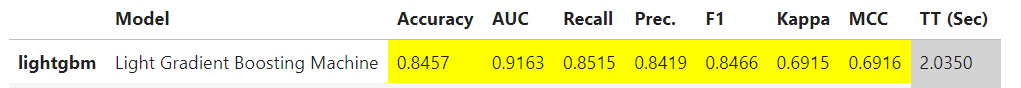

In [ ]:
Accuracy:  0.7730029000790931
Precision:  0.700607976294282
Recall:  0.6988183671063048
F1 Score:  0.6996982889060965

In [28]:
# Saving model and pickle file
pickle.dump(df,open('df.pkl','wb'))
pickle.dump(pipe,open('pipe.pkl','wb'))